In [1]:
from typing import Literal, List
from pathlib import Path, PosixPath
import tarfile
import urllib
import re
import math as mt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from bs4 import BeautifulSoup

from urlextract import URLExtract
from email import policy, message
from email.parser import BytesParser
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score)
from sklearn.naive_bayes import MultinomialNB


IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
stemmer = SnowballStemmer("english")
url_extractor = URLExtract()


#! STEP 1: Fetch the data


def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (
        ("easy_ham", "ham", ham_url),
        ("spam", "spam", spam_url),
    ):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]


# * Fetch the data and list the filenames
ham_dir, spam_dir = fetch_spam_data()
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

common_divisor = mt.gcd(len(ham_filenames), len(spam_filenames))
ham_sample_size = len(ham_filenames) // common_divisor
spam_sample_size = len(spam_filenames) // common_divisor


print(f"Number of ham emails: {len(ham_filenames)}")
print(f"Number of spam emails: {len(spam_filenames)}")
print("Total number of emails:", len(ham_filenames) + len(spam_filenames))
print(f"The ratio of ham to spam emails is {ham_sample_size}:{spam_sample_size}")


#! STEP 2: Parse the emails
EmailType = Literal["ham", "spam"]


def load_email(filename: Path):
    try:
        with open(filename, "rb") as f:
            return BytesParser(policy=policy.default).parse(f)
    except Exception as e:
        print(f"Could not load email {filename}: {e}")
        return None


def display_email_info(email) -> None:
    print(type(email))
    is_multipart = email.is_multipart()
    content_type = email.get_content_type()
    print(f"Subject: {email.get('subject')}")
    print(f"From: {email.get('from')}")
    print(f"Is multipart: {is_multipart}")
    print(f"Content type: {content_type}")


print("=== HAM EMAIL ===")
ham_email = load_email(ham_filenames[0])
display_email_info(ham_email)

print("\n=== SPAM EMAIL ===")
spam_email = load_email(spam_filenames[0])
display_email_info(spam_email)


#! STEP 3: Preprocess the emails


def parse_html_to_text(html) -> str:
    """Convert HTML to clean plain text"""
    soup = BeautifulSoup(html, "lxml")

    for element in soup(["script", "style"]):
        element.decompose()

    # Get text with separator between elements
    text = soup.get_text(separator=" ", strip=True)
    return text


def email_to_text(email: message.EmailMessage) -> str:
    """Convert an email to plain text."""
    text_parts = []  # Better name

    # Add subject
    email_subject = email.get("subject", "")
    if email_subject:
        text_parts.append(email_subject)

    if not email.is_multipart():
        content_type = email.get_content_type()
        try:
            content = email.get_content()
            if content_type == "text/plain":
                text_parts.append(content)
            elif content_type == "text/html":
                text_parts.append(parse_html_to_text(content))
        except:
            content = str(email.get_payload())
            text_parts.append(content)
    else:
        for part in email.walk():
            part_content_type = part.get_content_type()
            try:
                if part_content_type == "text/plain":
                    text_parts.append(part.get_content())
                elif part_content_type == "text/html":
                    text_parts.append(parse_html_to_text(part.get_content()))
            except:
                continue

    return " ".join(text_parts)


#! STEP 4: Create Dataset


def load_all_emails(filenames: List[Path]):
    emails = []
    for filename in filenames:
        try:
            email = load_email(filename)
            emails.append(email)
        except Exception as e:
            print(f"Error loading email {filename}: {e}")
            continue
    return emails


ham_emails = load_all_emails(ham_filenames)
spam_emails = load_all_emails(spam_filenames)


def create_dataset(
    ham_emails: List[message.EmailMessage], spam_emails: List[message.EmailMessage]
):
    texts = []
    labels = []

    for email in ham_emails:
        text = email_to_text(email)
        texts.append(text)
        labels.append(0)  # Ham label

    for email in spam_emails:
        text = email_to_text(email)
        texts.append(text)
        labels.append(1)  # Spam label

    return pd.DataFrame({"text": texts, "label": labels})


def create_dataset_np(
    ham_emails: List[message.EmailMessage], spam_emails: List[message.EmailMessage]
):
    X = np.array(
        [email_to_text(email) for email in ham_emails + spam_emails], dtype=object
    )
    y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))
    return X, y


X, y = create_dataset_np(ham_emails, spam_emails)

print(f"Loaded {len(ham_emails)} ham emails")
print(f"Loaded {len(spam_emails)} spam emails")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFirst 5 labels: {y[:5]}")
print(f"Last 5 labels: {y[-5:]}")
print(f"\nSample text (first 150 chars):\n{X[0][:150]}")


#! STEP 5: Split the dataset
# * stratify=y: This is the most important part for classification. It ensures the proportion of classes is the same in both sets. If your data is 90% "ham" and 10% "spam," stratify makes sure both your training and testing sets are also 90/10. Without it, you might accidentally end up with all the "spam" in your test set and none in your training set!
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} emails")
print(f"Testing set size: {X_test.shape[0]} emails")

print(f"Training set: {np.bincount(y_train)} (ham, spam)")
print(f"Testing set: {np.bincount(y_test)} (ham, spam)")

print(f"\nFirst 5 training labels: {y_train[:5]}")
print(f"First 5 testing labels: {y_test[:5]}")

#! STEP 6: Text preprocessing and stemming


def urlExtractor(text):
    return url_extractor.find_urls(text)


def convert_urls(text: str) -> str:
    urls = urlExtractor(text)
    for url in urls:
        text = re.sub(re.escape(url), " URL ", text)
    return text


def preprocess_text(
    text: str,
    lower_case=True,
    replace_urls=True,
    replace_emails=True,
    replace_numbers=True,
    remove_punctuation=True,
    stemming=True,
):
    # 1. Lowercase
    if lower_case:
        text = text.lower()

    # 2. Replace URLs
    if replace_urls:
        text = convert_urls(text)

    # 3. Replace emails
    if replace_emails:
        email_pattern = r"[\w\.-]+@[\w\.-]+\.\w+"
        text = re.sub(email_pattern, " EMAIL ", text)

    # 4. Replace numbers
    if replace_numbers:
        number_pattern = r"\b\d+(\.\d+)?\b"
        text = re.sub(number_pattern, " NUMBER ", text)

    # 5. Remove unwanted punctuation
    if remove_punctuation:
        # keep ! $ % ' -
        text = re.sub(r"[^\w\s!\$%'\-]", " ", text)

    # 6. Stemming
    if stemming:
        words = text.split()
        words = [stemmer.stem(word) for word in words]
        text = " ".join(words)

    # 7. Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


class TextPreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lower_case=True,
        replace_urls=True,
        replace_emails=True,
        replace_numbers=True,
        remove_punctuation=True,
        stemming=True,
    ):
        self.lower_case = lower_case
        self.replace_urls = replace_urls
        self.replace_emails = replace_emails
        self.replace_numbers = replace_numbers
        self.remove_punctuation = remove_punctuation
        self.stemming = stemming

    def fit(self, X, y=None):
        return self  # No training needed

    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            cleaned = preprocess_text(
                text,
                lower_case=self.lower_case,
                replace_urls=self.replace_urls,
                replace_emails=self.replace_emails,
                replace_numbers=self.replace_numbers,
                remove_punctuation=self.remove_punctuation,
                stemming=self.stemming,
            )
            X_transformed.append(cleaned)

        return np.array(X_transformed)


#! STEP 7: Vectorization
# TF → Term Frequency
# How often a word appears in a document.

# IDF → Inverse Document Frequency
# How rare that word is across all documents.

tfidi_vectorizer = TfidfVectorizer(
    lowercase=False,  # Already done in preprocessingp
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=3,  # Ignore very rare words
    max_df=0.9,  # Ignore very common words
    max_features=10000,
    stop_words=None,
    sublinear_tf=True,
    binary=False,
)

#! Create Pipeline
pipeline = Pipeline([
    ("preprocessor", TextPreprocessingTransformer()),
    ("vectorizer", tfidi_vectorizer),
    ("classifier", MultinomialNB(alpha=0.1)), 
])

# ! STEP 8: Train the model and evaluate
print("=== Classification Report ===")
# Train the entire pipeline
print("Training pipeline...")
pipeline.fit(X_train, y_train)

# Make predictions
print("Making predictions...")

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))
print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

print("Training complete!")

Number of ham emails: 2500
Number of spam emails: 500
Total number of emails: 3000
The ratio of ham to spam emails is 5:1
=== HAM EMAIL ===
<class 'email.message.EmailMessage'>
Subject: Re: New Sequences Window
From: Robert Elz <kre@munnari.OZ.AU>
Is multipart: False
Content type: text/plain

=== SPAM EMAIL ===
<class 'email.message.EmailMessage'>
Subject: Life Insurance - Why Pay More?
From: 12a1mailbot1@web.de
Is multipart: False
Content type: text/html
Loaded 2500 ham emails
Loaded 500 spam emails

X shape: (3000,)
y shape: (3000,)

First 5 labels: [0 0 0 0 0]
Last 5 labels: [1 1 1 1 1]

Sample text (first 150 chars):
Re: New Sequences Window     Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>

Training set size: 2400 emails
Testing set size: 600 emails
Training set: [2000  400] (ham, spam)
Testing set: [500 100] (ham, spam)

First 5 training labels: [0 0 0 0 0]
First 5 testing labels: [1 0 0 0 0]
=== Classific


=== Confusion Matrix ===
[[500   0]
 [  8  92]]

Breakdown:
True Negatives (Ham→Ham): 500
False Positives (Ham→Spam): 0 ← CRITICAL!
False Negatives (Spam→Ham): 8 ← Spam that got through
True Positives (Spam→Spam): 92


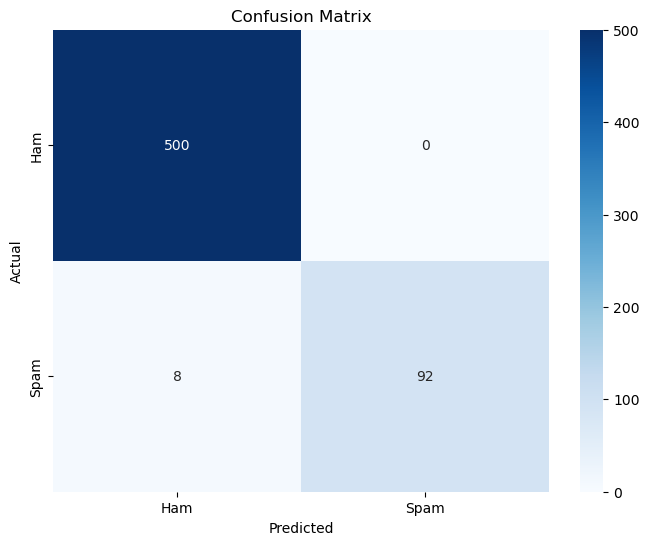


=== Prediction Probability Stats ===
Spam probabilities - Min: 0.0000, Max: 1.0000
Mean spam probability for actual spam: 0.9205
Mean spam probability for actual ham: 0.0046


In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n=== Confusion Matrix ===")
print(cm)
print("\nBreakdown:")
print(f"True Negatives (Ham→Ham): {cm[0,0]}")
print(f"False Positives (Ham→Spam): {cm[0,1]} ← CRITICAL!")
print(f"False Negatives (Spam→Ham): {cm[1,0]} ← Spam that got through")
print(f"True Positives (Spam→Spam): {cm[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig(IMAGES_PATH / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Get prediction probabilities
y_pred_proba = pipeline.predict_proba(X_test)
print("\n=== Prediction Probability Stats ===")
print(f"Spam probabilities - Min: {y_pred_proba[:, 1].min():.4f}, Max: {y_pred_proba[:, 1].max():.4f}")
print(f"Mean spam probability for actual spam: {y_pred_proba[y_test==1, 1].mean():.4f}")
print(f"Mean spam probability for actual ham: {y_pred_proba[y_test==0, 1].mean():.4f}")